Практическое задание к уроку 5

Обучить детектор объектов с помощью TensorFlow Object Detection API
Библиотеки: [Python, Tensorflow

In [226]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [227]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1618454 sha256=8f7902b8afe028dee624a9dc00afa5f02a70f86af20ed506243de35a37476c20
  Stored in directory: /tmp/pip-ephem-wheel-cache-tuvhbidd/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [228]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc

from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage


from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
#from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
import tensorflow_hub as hub

In [ ]:
tf.test.gpu_device_name

<function tensorflow.python.framework.test_util.gpu_device_name>

In [229]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)

In [320]:
train_image_dir='models/research/train'

In [321]:
train_images_np = []
for i in range(1, 7):
    image_path = os.path.join(train_image_dir, 'train' + str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

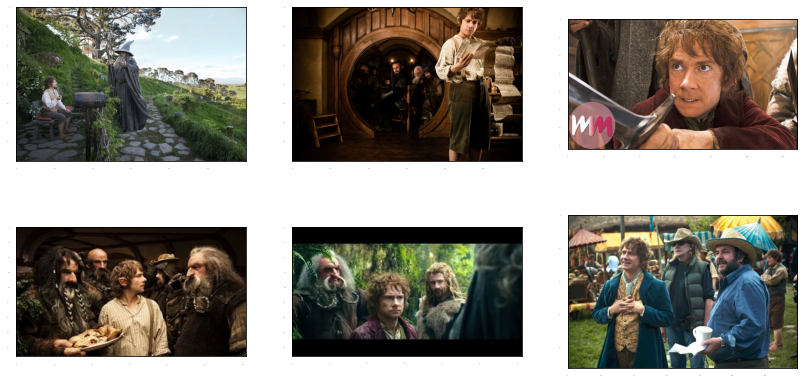

In [322]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image)
plt.show()

In [323]:
gt_boxes = [
             np.array([[0.4374683 , 0.10416667, 0.87080163, 0.2675    ]], dtype=np.float32),
             np.array([[0.0024683 , 0.61771741, 0.98913496, 0.86355075]], dtype=np.float32),
             np.array([[0.0074683 , 0.3445992 , 0.82580163, 0.7758492 ]], dtype=np.float32),
             np.array([[0.25413496, 0.35081967, 0.9924683 , 0.68852459]], dtype=np.float32),
             np.array([[0.37413496, 0.24836601, 0.86580163, 0.56535948]], dtype=np.float32),
             np.array([[0.11913496, 0.10050251, 0.9974683 , 0.46805456]], dtype=np.float32),
 ]#

In [397]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):

  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
 # if image_name:
 #   plt.imsave(image_name, image_np_with_annotations)
 # else:
  plt.imshow(image_np_with_annotations)

In [325]:
hobbit_class_id=0
category_index = {hobbit_class_id: {'id': hobbit_class_id, 'name': 'hobbit'}}

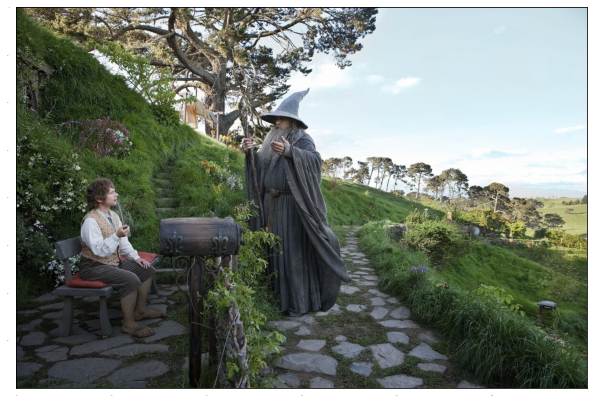

In [ ]:
plt.imshow(train_images_np[0])

In [326]:
label_id_offset = 1
num_classes=1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [338]:
num_classes = 1
#pipeline_config ='models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

In [343]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

 # #@tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)


In [ ]:

batch_size = 1
num_batches = 100


print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=0.8130549
batch 10 of 100, loss=0.66517043
batch 20 of 100, loss=1.0489674
batch 30 of 100, loss=0.82310516
batch 40 of 100, loss=0.64555585
batch 50 of 100, loss=0.78071123
batch 60 of 100, loss=0.7594309
batch 70 of 100, loss=0.8113234


In [456]:
test_image=train_images_np[0]

converted_img  = tf.image.convert_image_dtype(test_image, tf.float32)[tf.newaxis, ...]
input_tensor = tf.convert_to_tensor(converted_img, dtype=tf.float32)
preprocessed_image, shapes = detection_model.preprocess(input_tensor)
prediction_dict = detection_model.predict(preprocessed_image, shapes)
detections=detection_model.postprocess(prediction_dict, shapes)

[0.18289512]


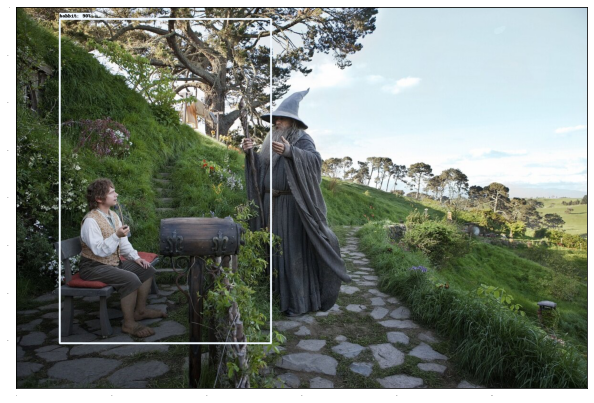

In [459]:
i=2
print(detections['detection_scores'][0][i:i+1].numpy())
plot_detections(test_image,
                detections['detection_boxes'][0][i:i+1].numpy(),
                [hobbit_class_id],
                [0.9]
                ,category_index)
